In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

In [4]:
train_data = tfds.load('cats_vs_dogs', split='train[:80%]', as_supervised=True)
validation_data = tfds.load('cats_vs_dogs', split='train[80%:90%]', as_supervised=True)
test_data = tfds.load('cats_vs_dogs', split='train[-10%:]', as_supervised=True)

In [5]:
type(train_data)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [6]:
def augment_images(image, label):
  
  # cast to float
  image = tf.cast(image, tf.float32)
  # normalize the pixel values
  image = (image/255)
  # resize to 300 x 300
  image = tf.image.resize(image,(300,300))

  return image, label

# use the utility function above to preprocess the images
augmented_training_data = train_data.map(augment_images)

# shuffle and create batches before training
train_batches = augmented_training_data.shuffle(1024).batch(32)

In [7]:
model = Sequential()
model.add(Conv2D(16,input_shape=(300,300,3),kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(1,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 37, 37, 64)       0

In [8]:
# Training will take around 30 minutes to complete using a GPU. Time for a break!

model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=tf.keras.optimizers.RMSprop(lr=0.001))
model.fit(train_batches,epochs=2)

Epoch 1/2
582/582 [==============================] - 69s 96ms/step - loss: 0.6649 - accuracy: 0.5851
Epoch 2/2
582/582 [==============================] - 55s 92ms/step - loss: 0.6410 - accuracy: 0.6209


In [9]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 300, 300, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 150, 150, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496 

In [10]:
def show_cam(image_value, features, results):
  '''
  Displays the class activation map of an image

  Args:
    image_value (tensor) -- preprocessed input image with size 300 x 300
    features (array) -- features of the image, shape (1, 37, 37, 128)
    results (array) -- output of the sigmoid layer
  '''

  # there is only one image in the batch so we index at `0`
  features_for_img = features[0]
  prediction = results[0]

  # there is only one unit in the output so we get the weights connected to it
  class_activation_weights = gap_weights[:,0]

  # upsample to the image size
  class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
  
  # compute the intensity of each feature in the CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  # visualize the results
  print(f'sigmoid output: {results}')
  print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
  plt.figure(figsize=(8,8))
  plt.imshow(cam_output, cmap='jet', alpha=0.5)
  
  plt.show()


In [11]:
!wget -O cat1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
!wget -O cat2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
!wget -O catanddog.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/catanddog.jpeg
!wget -O dog1.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog1.jpeg
!wget -O dog2.jpg https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/dog2.jpeg

--2023-03-28 16:29:21--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat1.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.213.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414826 (405K) [image/jpeg]
Saving to: ‘cat1.jpg’

cat1.jpg            100%[===================>] 405.10K  --.-KB/s    in 0.003s  

2023-03-28 16:29:22 (127 MB/s) - ‘cat1.jpg’ saved [414826/414826]

--2023-03-28 16:29:22--  https://storage.googleapis.com/tensorflow-1-public/tensorflow-3-temp/MLColabImages/cat2.jpeg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.213.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 599639 (586K) [image/jpeg]
Sav

1/1 [==============================] - 0s 268ms/step
sigmoid output: [[0.63408905]]
prediction: dog


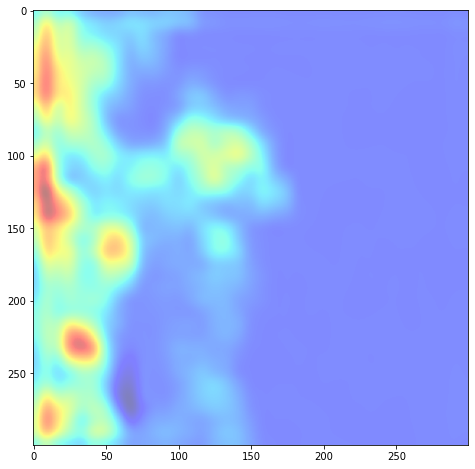

1/1 [==============================] - 0s 21ms/step
sigmoid output: [[0.39918342]]
prediction: cat


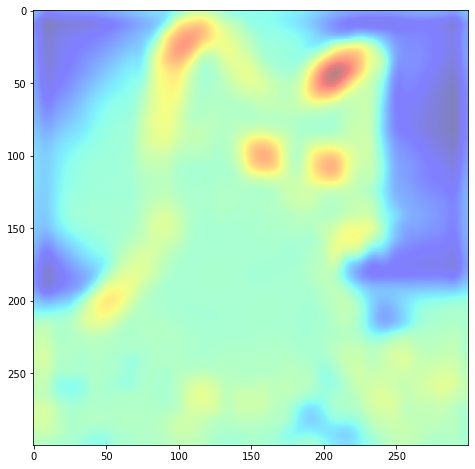

1/1 [==============================] - 0s 20ms/step
sigmoid output: [[0.4558812]]
prediction: cat


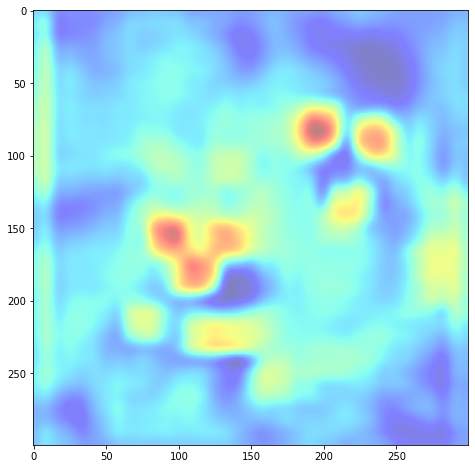

1/1 [==============================] - 0s 20ms/step
sigmoid output: [[0.5243492]]
prediction: dog


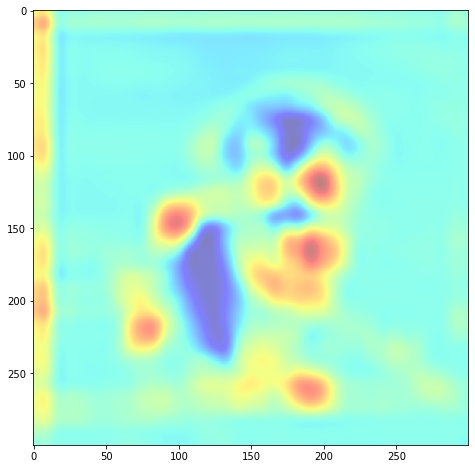

1/1 [==============================] - 0s 35ms/step
sigmoid output: [[0.64783174]]
prediction: dog


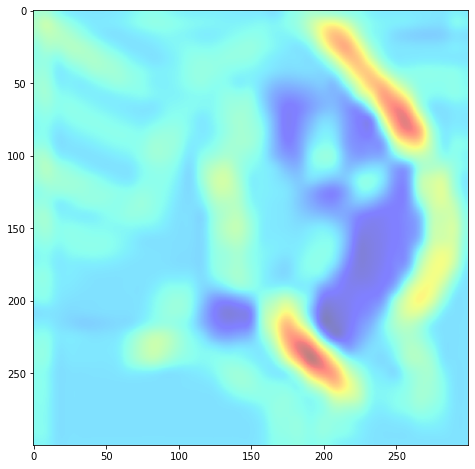

In [12]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (300,300)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)

convert_and_classify('cat1.jpg')
convert_and_classify('cat2.jpg')
convert_and_classify('catanddog.jpg')
convert_and_classify('dog1.jpg')
convert_and_classify('dog2.jpg')

ground truth: cat
1/1 [==============================] - 0s 22ms/step
sigmoid output: [[0.41927078]]
prediction: cat


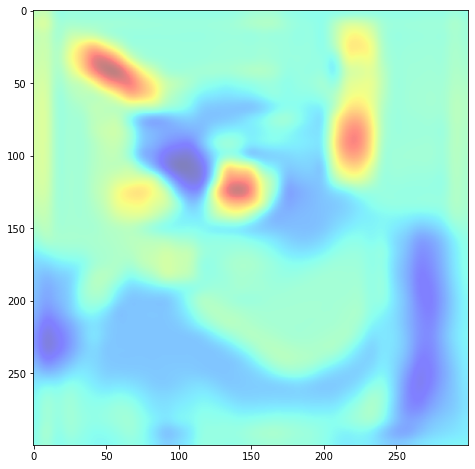

ground truth: dog
1/1 [==============================] - 0s 26ms/step
sigmoid output: [[0.43670434]]
prediction: cat


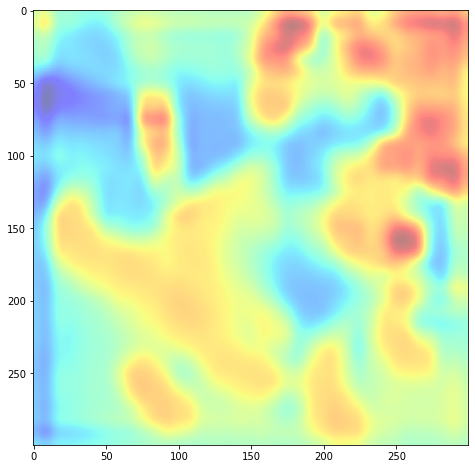

ground truth: dog
1/1 [==============================] - 0s 21ms/step
sigmoid output: [[0.35583204]]
prediction: cat


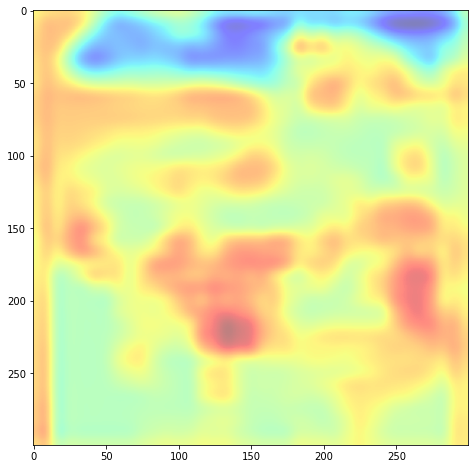

ground truth: cat
1/1 [==============================] - 0s 25ms/step
sigmoid output: [[0.4894007]]
prediction: cat


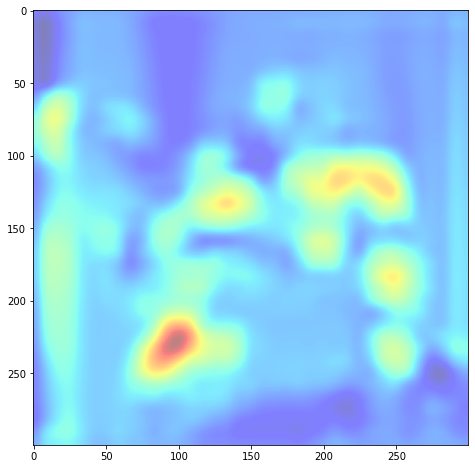

ground truth: cat
1/1 [==============================] - 0s 20ms/step
sigmoid output: [[0.45801225]]
prediction: cat


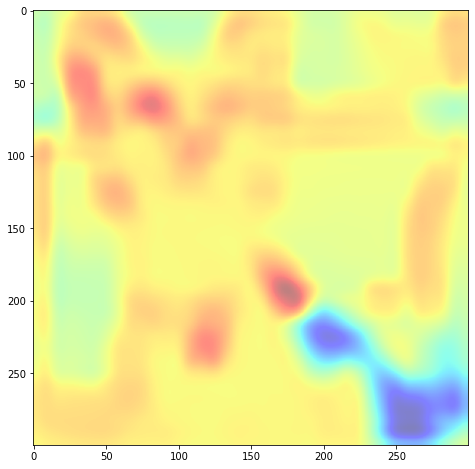

In [13]:
# preprocess the test images
augmented_test_data = test_data.map(augment_images)
test_batches = augmented_test_data.batch(1)


for img, lbl in test_batches.take(5):
  print(f"ground truth: {'dog' if lbl else 'cat'}")
  features,results = cam_model.predict(img)
  show_cam(img, features, results)